In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("data_2.txt", "r") as f:
    data = f.read()

In [3]:
head_tail = [float(number) for number in data.strip().split("   ")][:1000]
head_tail = np.array(head_tail, dtype=np.int)-1
A_B = [float(number) for number in data.strip().split("   ")][1000:]
A_B = np.array(A_B, dtype=np.int)-1

In [4]:
np.unique(head_tail, return_counts=True)

(array([0, 1]), array([608, 392]))

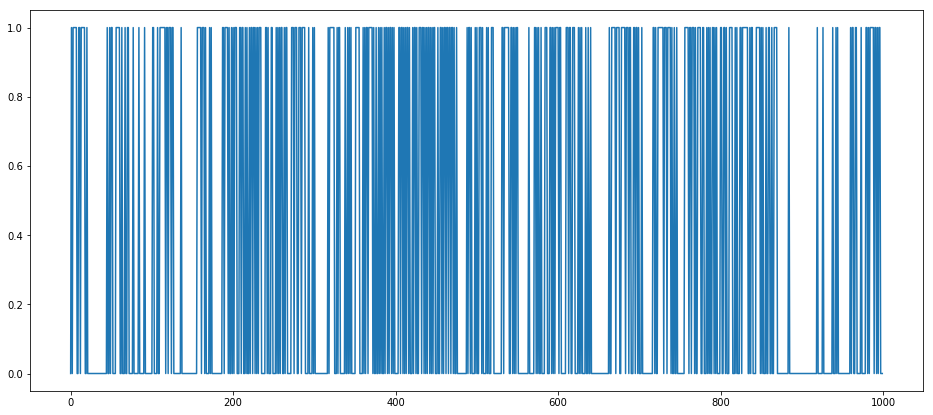

In [5]:
plt.figure(figsize=(16,7))
plt.plot(head_tail)
plt.show()

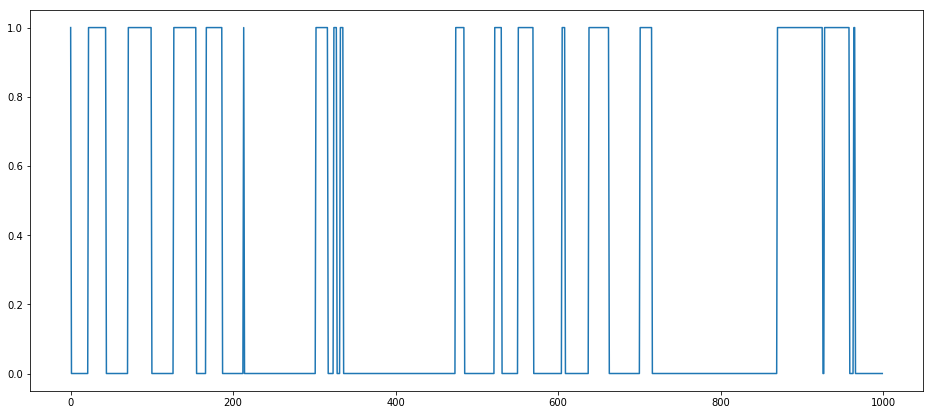

In [6]:
# poisson, geometric ,這次丟A，下一個會換B的機率是多少
plt.figure(figsize=(16,7))
plt.plot(A_B)
plt.show()

## solve the learning problem of HMM

In [7]:
num_states = 2
num_obs = 2
pi = 0.5
A = np.ones( (num_states, num_states) )
A = A / np.sum(A,1)
B = np.ones( (num_states, num_obs) )
B = B / np.sum(B,1)


def forward(obs_seq):
    """前向算法"""
    N = A.shape[0]
    T = len(obs_seq)
    
    # F保存前向概率矩阵
    F = np.zeros((N,T))
    F[:,0] = pi * B[:, obs_seq[0]]

    for t in range(1, T):
        for n in range(N):
            F[n,t] = np.dot(F[:,t-1], (A[:,n])) * B[n, obs_seq[t]]

    return F

def backward(obs_seq):
    """后向算法"""
    N = A.shape[0]
    T = len(obs_seq)
    # X保存后向概率矩阵
    X = np.zeros((N,T))
    X[:,-1:] = 1

    for t in reversed(range(T-1)):
        for n in range(N):
            X[n,t] = np.sum(X[:,t+1] * A[n,:] * B[:, obs_seq[t+1]])

    return X
def baum_welch_train(observations, A, B, pi, criterion=0.005):
    """Baum-Weich algorithm"""
    n_states = A.shape[0]
    n_samples = len(observations)

    done = False
    while not done:
        # alpha_t(i) = P(O_1 O_2 ... O_t, q_t = S_i | hmm)
        # Initialize alpha
        alpha = forward(observations)

        # beta_t(i) = P(O_t+1 O_t+2 ... O_T | q_t = S_i , hmm)
        # Initialize beta
        beta = backward(observations)
        # ξ_t(i,j)=P(i_t=q_i,i_{i+1}=q_j|O,λ)
        xi = np.zeros((n_states,n_states,n_samples-1))
        for t in range(n_samples-1):
            denom = np.dot(np.dot(alpha[:,t].T, A) * B[:,observations[t+1]].T, beta[:,t+1])
            for i in range(n_states):
                numer = alpha[i,t] * A[i,:] * B[:,observations[t+1]].T * beta[:,t+1].T
                xi[i,:,t] = numer / denom

        # γ_t(i)：gamma_t(i) = P(q_t = S_i | O, hmm)
        gamma = np.sum(xi,axis=1)
        # Need final gamma element for new B
        # xi的第三维长度n_samples-1，少一个，所以gamma要计算最后一个
        prod =  (alpha[:,n_samples-1] * beta[:,n_samples-1]).reshape((-1,1))
        gamma = np.hstack((gamma,  prod / np.sum(prod))) #append one more to gamma!!!
        
        # 更新模型参数
        newpi = gamma[:,0]
        newA = np.sum(xi,2) / np.sum(gamma[:,:-1],axis=1).reshape((-1,1))
        newB = np.copy(B)
        num_levels = B.shape[1]
        sumgamma = np.sum(gamma,axis=1)
        for lev in range(num_levels):
            mask = observations == lev
            newB[:,lev] = np.sum(gamma[:,mask],axis=1) / sumgamma
        
        # 检查是否满足阈值
        if np.max(abs(pi - newpi)) < criterion and \
                        np.max(abs(A - newA)) < criterion and \
                        np.max(abs(B - newB)) < criterion:
            done = 1
        A, B, pi = newA, newB, newpi
    return newA, newB, newpi

In [8]:
A_, B_, pi_ = baum_welch_train(head_tail, A, B, pi)

In [9]:
print("transition matrix:\n",A_)
print("emission matrix:\n",B_)
print("initial probability:",pi_)

transition matrix:
 [[0.5 0.5]
 [0.5 0.5]]
emission matrix:
 [[0.608 0.392]
 [0.608 0.392]]
initial probability: [0.5 0.5]


In [10]:
# check answer 
A_B

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## try hmmlearn

In [11]:
from hmmlearn import hmm

In [53]:
# np.random.seed(42)
model = hmm.MultinomialHMM(n_components=2,n_iter=10,verbose=True)

In [54]:
model.fit(head_tail.reshape(1000,1)) # shape (n_samples, n_feature) => (1000,1)
print(model)
print(model.monitor_.converged)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=2,
        n_iter=10, params='ste',
        random_state=<mtrand.RandomState object at 0x7f2375339510>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=True)
True


         1        -975.3334             +nan
         2        -666.6637        +308.6697
         3        -664.4902          +2.1735
         4        -662.8425          +1.6477
         5        -661.6590          +1.1835
         6        -660.8698          +0.7891
         7        -660.3725          +0.4974
         8        -660.0608          +0.3117
         9        -659.8512          +0.2095
        10        -659.6895          +0.1617


In [55]:
model.emissionprob_

array([[0.82866359, 0.17133641],
       [0.0980639 , 0.9019361 ]])

In [56]:
model.transmat_

array([[0.7851191 , 0.2148809 ],
       [0.49583051, 0.50416949]])

In [57]:
model.startprob_

array([9.99999998e-01, 1.52493819e-09])

In [58]:
model.score(head_tail.reshape(1000,1))

-659.5442726686613